In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r"dataset\company_01_merge_sales.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# Plot sales
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["sales"], marker="o", linestyle="-")
plt.title("Monthly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [ ]:
# project

In [ ]:
def create_features(df, target_col="sales", max_lags=24, rolling_windows=[3, 12]):
    # Copy dataframe
    df = df.copy()
    
    # --- Lags ---
    for lag in range(1, max_lags + 1):
        df[f"lag_{lag}"] = df[target_col].shift(lag)
    
    # --- Rolling Statistics ---
    for window in rolling_windows:
        df[f"rolling_mean_{window}"] = df[target_col].rolling(window).mean().shift(1)
        df[f"rolling_median_{window}"] = df[target_col].rolling(window).median().shift(1)
    
    # --- Date Features ---
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    
    # --- Differencing ---
    df["diff_monthly"] = df[target_col].diff(1)  # Month-over-month change
    df["diff_yearly"] = df[target_col].diff(12)   # Year-over-year change
    
    # Drop rows with NaN (from lags/rolling windows)
    df = df.dropna()
    return df

# Generate features
df_feat = create_features(df, rolling_windows=[3, 6, 12])

In [ ]:
corr_matrix = df_feat.corr()
target_corr = corr_matrix["sales"].sort_values(ascending=False)
print(target_corr)

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

# Split data
X = df_feat.drop(columns=["sales"])
y = df_feat["sales"]

# Use time-series cross-validation
tss = TimeSeriesSplit(n_splits=3)
model = LassoCV(cv=tss, max_iter=10_000)
model.fit(X, y)

selected_features = X.columns[model.coef_ != 0].tolist()
print("Selected Features:", selected_features)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

def train_model(df, target_col="sales"):
    # Generate features
    df_feat = create_features(df, target_col=target_col)
    
    # Split data
    X = df_feat.drop(columns=[target_col])
    y = df_feat[target_col]
    
    # Train-test split (last 12 months as test)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Train model (Gradient Boosting for nonlinear patterns)
    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1)
    model.fit(X_train, y_train)
    
    # Evaluate
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    
    print(f"R²: {r2:.2f}, MAE: {mae:.2f}")
    return model, X.columns.tolist()

# Run the model
model, features_used = train_model(df)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Load data
data = r"dataset\company_01_merge_sales.csv"
df = pd.read_csv(data, parse_dates=['date'])
df = df.set_index('date').asfreq('MS').sort_index()

# Feature Engineering Function (simplified)
def create_features(df, target, max_lags=12):
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    # Lag features
    for lag in [1, 12, 24]:  # Focus on yearly patterns
        df[f'lag_{lag}'] = df[target].shift(lag)
    
    # Rolling statistics
    for window in [3, 6, 12]:
        df[f'rolling_mean_{window}'] = df[target].shift(1).rolling(window).mean()
    
    # Year-over-year difference
    df['yoy_diff'] = df[target].shift(12) - df[target].shift(24)
    
    return df.dropna()

# Create features
target = 'sales'
model_df = create_features(df, target)

# Train/test split
test_size = 12
train = model_df.iloc[:-test_size]
test = model_df.iloc[-test_size:]

# Define preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['month']),
    ('num', 'passthrough', [c for c in model_df.columns if c != target])
])

# Build pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        early_stopping_rounds=50,
        random_state=42
    ))
])

# Time-series validation
tscv = TimeSeriesSplit(n_splits=3)
X_train = train.drop(columns=[target])
y_train = train[target]

# Create single validation set for early stopping
val_size = 12  # Last year before test
X_val = X_train.iloc[-val_size:]
y_val = y_train.iloc[-val_size:]
X_train = X_train.iloc[:-val_size]
y_train = y_train.iloc[:-val_size]

model.fit(
    X_train, y_train,
    regressor__eval_set=[(X_val, y_val)]
)

# Forecast
X_test = test.drop(columns=[target])
y_pred = model.predict(X_test)
mae = mean_absolute_error(test[target], y_pred)
print(f"MAE: {mae:,.2f}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import TimeSeriesSplit

# Load and prepare data
def load_data(file_path):
    df = pd.read_csv(
        file_path,
        parse_dates=['date'],
        date_parser=lambda x: pd.to_datetime(x, format='%Y-%m')
    )
    df = df.set_index('date').asfreq('MS').sort_index()
    return df

# Automated feature engineering
def create_features(df, target_name='sales'):
    df = df.copy()
    y = df[target_name]
    
    # Time features
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['time_idx'] = np.arange(len(df))
    
    # Lag features (dynamic range based on data length)
    max_lags = min(24, len(df)//2)  # Ensure we don't create too many lags
    for lag in [1, 3, 6, 12, 24]:
        if lag <= max_lags:
            df[f'lag_{lag}'] = y.shift(lag)
    
    # Rolling statistics
    for window in [3, 6, 12]:
        df[f'rolling_mean_{window}'] = y.shift(1).rolling(window).mean()
        df[f'rolling_std_{window}'] = y.shift(1).rolling(window).std()
        df[f'rolling_min_{window}'] = y.shift(1).rolling(window).min()
        df[f'rolling_max_{window}'] = y.shift(1).rolling(window).max()
    
    # Trend decomposition using STL
    stl = STL(y, period=12, seasonal=13)
    res = stl.fit()
    df['trend'] = res.trend
    df['seasonal'] = res.seasonal
    df['residual'] = res.resid
    
    # Fourier terms for seasonality
    for k in range(1, 4):
        df[f'fourier_sin_{k}'] = np.sin(2 * k * np.pi * df.index.month / 12)
        df[f'fourier_cos_{k}'] = np.cos(2 * k * np.pi * df.index.month / 12)
    
    # Differencing
    df['diff_1'] = y.diff(1)
    df['diff_12'] = y.diff(12)
    
    # Interaction terms
    df['trend_season_interaction'] = df['trend'] * df['seasonal']
    
    # Drop original target and keep features only
    features_df = df.drop(columns=[target_name]).copy()
    return features_df, y

# Dynamic feature selection
def select_features(X, y):
    selector = SelectFromModel(
        XGBRegressor(n_estimators=100, importance_type='gain'),
        threshold='median'
    )
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    return selected_features

# Main pipeline
def main():
    # Load data
    df = load_data(r'dataset\company_01_merge_sales.csv')
    
    # Create features
    X, y = create_features(df)
    
    # Train-test split
    test_size = 12
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    # Preprocessing
    preprocessor = ColumnTransformer([
        ('time_features', StandardScaler(), ['time_idx', 'trend']),
        ('month_encoder', OneHotEncoder(handle_unknown='ignore'), ['month']),
        ('numeric_features', StandardScaler(), X.columns.difference(['month', 'time_idx', 'trend']))
    ])
    
    # Model pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', SelectFromModel(XGBRegressor())),
        ('regressor', XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            early_stopping_rounds=50,
            random_state=42
        ))
    ])
    
    # Time-series validation
    tscv = TimeSeriesSplit(n_splits=3)
    splits = list(tscv.split(X_train))
    
    # Fit model with early stopping
    best_score = float('inf')
    for train_idx, val_idx in splits:
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(
            X_train_fold, y_train_fold,
            regressor__eval_set=[(model[:-1].transform(X_val_fold), y_val_fold)]
        )
        
        # Track best iteration
        current_score = mean_absolute_error(y_val_fold, model.predict(X_val_fold))
        if current_score < best_score:
            best_model = model.named_steps['regressor'].best_iteration
            model.named_steps['regressor'].set_params(n_estimators=best_model)
            best_score = current_score
    
    # Final evaluation
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Test MAE: {mae:,.2f}")
    
    # Feature importance
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    selected_features = feature_names[model.named_steps['feature_selector'].get_support()]
    importance = model.named_steps['regressor'].feature_importances_
    
    print("\nTop Features:")
    for feat, imp in sorted(zip(selected_features, importance), key=lambda x: -x[1]):
        print(f"{feat}: {imp:.3f}")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import TimeSeriesSplit

def load_data(file_path):
    df = pd.read_csv(
        file_path,
        parse_dates=['date'],
        date_parser=lambda x: pd.to_datetime(x, format='%Y-%m')
    )
    df = df.set_index('date').asfreq('MS').sort_index()
    return df

def create_features(df, target_name='sales'):
    df = df.copy()
    y = df[target_name]
    
    # Time features
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['time_idx'] = np.arange(len(df))
    
    # Lag features
    for lag in [1, 3, 6, 12, 24]:
        if lag <= len(df)//2:
            df[f'lag_{lag}'] = y.shift(lag)
    
    # Rolling statistics
    for window in [3, 6, 12]:
        df[f'rolling_mean_{window}'] = y.shift(1).rolling(window).mean()
        df[f'rolling_std_{window}'] = y.shift(1).rolling(window).std()
    
    # STL Decomposition
    stl = STL(y, period=12, seasonal=13)
    res = stl.fit()
    df['trend'] = res.trend
    df['seasonal'] = res.seasonal
    
    # Fourier terms
    for k in range(1, 4):
        df[f'fourier_sin_{k}'] = np.sin(2 * k * np.pi * df.index.month / 12)
        df[f'fourier_cos_{k}'] = np.cos(2 * k * np.pi * df.index.month / 12)
    
    # Differencing
    df['diff_1'] = y.diff(1)
    df['diff_12'] = y.diff(12)
    
    return df.dropna()

def main():
    # Load and prepare data
    df = load_data(r'dataset\data_in_millio')
    processed_df = create_features(df)
    
    # Split data
    test_size = 12
    train = processed_df.iloc[:-test_size]
    test = processed_df.iloc[-test_size:]
    
    X_train = train.drop(columns=['sales'])
    y_train = train['sales']
    X_test = test.drop(columns=['sales'])
    y_test = test['sales']
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('time', StandardScaler(), ['time_idx', 'trend']),
        ('month', OneHotEncoder(handle_unknown='ignore'), ['month']),
        ('scale', StandardScaler(), X_train.columns.difference(['month', 'time_idx', 'trend']))
    ])
    
    # Full pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            early_stopping_rounds=50,
            random_state=42
        ))
    ])
    
    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    best_score = float('inf')
    best_params = None
    
    for train_idx, val_idx in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Fit preprocessing on training fold
        model.fit(X_train_fold, y_train_fold)
        
        # Evaluate on validation set
        current_score = mean_absolute_error(y_val_fold, model.predict(X_val_fold))
        if current_score < best_score:
            best_score = current_score
            best_params = model.named_steps['regressor'].get_xgb_params()
    
    # Final training on full data with best parameters
    final_model = XGBRegressor(**best_params)
    final_model.fit(X_train, y_train)
    
    #

In [ ]:
#XGB regressor


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

def train_model(df, target_col="sales"):
    # Generate features
    df_feat = create_features(df, target_col=target_col)
    
    # Split data
    X = df_feat.drop(columns=[target_col])
    y = df_feat[target_col]
    
    # Train-test split (last 12 months as test)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Train model (Gradient Boosting for nonlinear patterns)
    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1)
    model.fit(X_train, y_train)
    
    # Evaluate
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    
    print(f"R²: {r2:.2f}, MAE: {mae:.2f}")
    return model, X.columns.tolist()

# Run the model
model, features_used = train_model(df)



In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import TimeSeriesSplit

# Load data
df = pd.read_csv('dataset/data_in_million.csv', parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m'))
df = df.set_index('date').asfreq('MS').sort_index()

# Feature Engineering
target = 'sales'
y = df[target].copy()

# Create time-based features
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

# Add lag features
for lag in [1, 3, 6, 12, 24]:
    df[f'lag_{lag}'] = y.shift(lag)

# Add rolling statistics
for window in [3, 6, 12]:
    df[f'rolling_mean_{window}'] = y.shift(1).rolling(window).mean()
    df[f'rolling_std_{window}'] = y.shift(1).rolling(window).std()

# STL Decomposition for trend extraction
stl = STL(y, period=12, seasonal=13)
res = stl.fit()
df['trend'] = res.trend
df['seasonal'] = res.seasonal

# Fourier terms for seasonality
for k in range(1, 4):
    df[f'fourier_sin_{k}'] = np.sin(2 * k * np.pi * df.index.month / 12)
    df[f'fourier_cos_{k}'] = np.cos(2 * k * np.pi * df.index.month / 12)

# Differencing features
df['diff_1'] = y.diff(1)
df['diff_12'] = y.diff(12)

# Drop rows with missing values
processed_df = df.dropna()

# Split data into train/test
test_size = 12
train = processed_df.iloc[:-test_size]
test = processed_df.iloc[-test_size:]

X_train = train.drop(columns=[target])
y_train = train[target]
X_test = test.drop(columns=[target])
y_test = test[target]

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('time_scaler', StandardScaler(), ['time_idx', 'trend']),
    ('month_encoder', OneHotEncoder(handle_unknown='ignore'), ['month']),
    ('feature_scaler', StandardScaler(), X_train.columns.difference(['month', 'time_idx', 'trend']))
])

# Create and train model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        # early_stopping_rounds=50,
        random_state=42
    ))
])

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
best_mae = float('inf')
best_model = None

for train_idx, val_idx in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    # Validate
    val_pred = model.predict(X_val_fold)
    current_mae = mean_absolute_error(y_val_fold, val_pred)
    
    # Track best model
    if current_mae < best_mae:
        best_mae = current_mae
        best_model = model.named_steps['regressor']

# Final training
model.named_steps['regressor'] = best_model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['regressor'].feature_importances_

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(10)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

C:\Users\binay\AppData\Local\Temp\ipykernel_26900\1484879872.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('dataset/data_in_million.csv', parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m'))


Top 10 Features:
           feature  importance
4           lag_12    0.392492
5           lag_24    0.174368
12        mom_diff    0.100531
2            lag_1    0.073018
0            month    0.060845
14   fourier_sin_1    0.042620
3            lag_2    0.034048
6   rolling_mean_3    0.033627
11  rolling_std_12    0.029490
15   fourier_cos_1    0.023713

Optimized Model Performance:
MAE: 153015.06
RMSE: 188102.79
R² Score: -0.1501


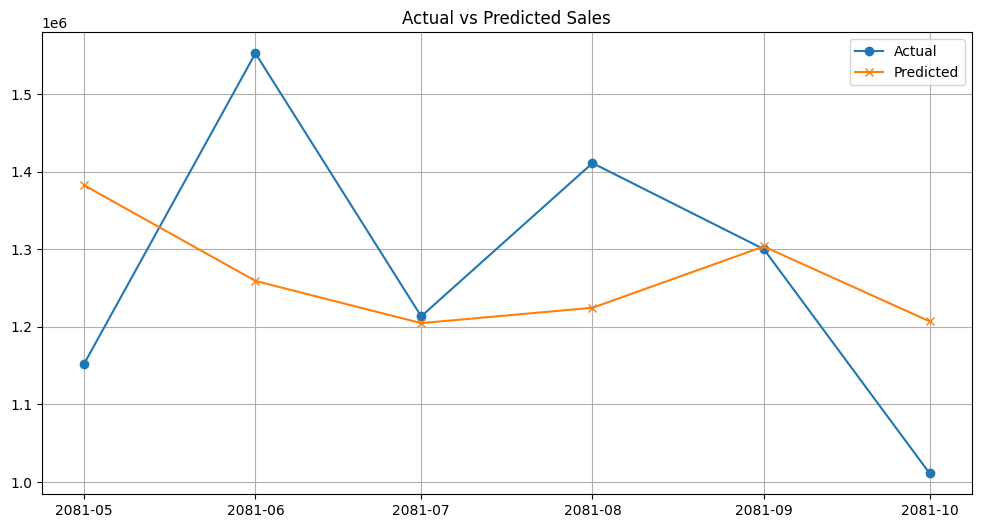

In [9]:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

data = pd.read_csv('dataset/data_in_million.csv', parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m'))
data = data.set_index('date').asfreq('MS').sort_index()


data['month'] = data.index.month
data['year'] = data.index.year

# Remove irrelevant feature for monthly data
# del data['dayofweek']

# Lag features based on ACF/PACF analysis
significant_lags = [1, 2, 12, 24]  # From ACF/PACF peaks
for lag in significant_lags:
    if lag < len(data):
        data[f'lag_{lag}'] = data['sales'].shift(lag)

# Rolling features with shift to prevent leakage
windows = [3, 6, 12]  # Optimized window sizes
for window in windows:
    data[f'rolling_mean_{window}'] = data['sales'].shift(1).rolling(window).mean()
    data[f'rolling_std_{window}'] = data['sales'].shift(1).rolling(window).std()

# Differencing features
data['mom_diff'] = data['sales'].diff(1)  # Month-over-month difference
data['yoy_diff'] = data['sales'].diff(12)  # Year-over-year difference

# Fourier terms for seasonality
for k in [1, 2]:
    data[f'fourier_sin_{k}'] = np.sin(2 * k * np.pi * data.index.month/12)
    data[f'fourier_cos_{k}'] = np.cos(2 * k * np.pi * data.index.month/12)

# Clean data
data.dropna(inplace=True)

# %%
# Train-Test Split (Time-series aware)
test_size = int(len(data) * 0.2)  # Last 20% as test
X = data.drop(columns=['sales'])
y = data['sales']
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# %%
# Feature Scaling (Optional for tree-based models)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# %%
# Optimized Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# %%
# Feature Importance Analysis
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features:")
print(feature_importances.head(10))

# %%
# Prediction and Evaluation
y_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nOptimized Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# %%
# Visualization of Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from 